In [51]:
import re
fin = open('StateGPSData.txt')
healthFile = open('HealthCareCoverage.csv')
birthFile = open('TeenBirthRates.csv')

stateList = {}
for line in fin:
    text = line.split()
    text2 = line.split("\u2028")
    key = text2[0].split(": ")[1]
    lat = text[-4]
    long = text[-1]
    stateList[key] = (float(long),float(lat))
print(stateList.keys())
    

dict_keys(['Louisiana', 'Minnesota', 'Oklahoma', 'Kansas', 'Wisconsin', 'Rhode Island', 'Indiana', 'Iowa', 'Massachusetts', 'Montana', 'New Hampshire', 'Arizona', 'Kentucky', 'Hawaii', 'Georgia', 'Idaho', 'Alabama', 'Nevada', 'Pennsylvania', 'Texas', 'North Dakota', 'North Carolina', 'West Virginia', 'New Mexico', 'New York', 'Tennessee', 'Delaware', 'Arkansas', 'South Carolina', 'Illinois', 'Nebraska', 'Vermont', 'Michigan', 'Ohio', 'New Jersey', 'Wyoming', 'Maine', 'Maryland', 'Florida', 'Connecticut', 'California', 'Virginia', 'Colorado', 'Alaska', 'South Dakota', 'Utah', 'Missouri', 'Mississippi', 'Washington', 'Oregon'])


In [52]:
print(stateList["Alabama"])

(-86.279118, 32.361538)


This code is for our data to have lat and long values that we can use to color our map. This will help us with displaying this data for the birth rates

In [53]:
healthList = []

rgx = re.compile("\(|\)|\"|\s")
for line1 in healthFile:
    text = line1.strip("\n").split(",")[0:4]
    # print(text)
    next(healthFile)
    
    healthList.append(text)
    
print(healthList[1])

['2006', 'Texas', '71%', '29%']


This parses out the health care coverage file. 

In [47]:
birthList = []
yearList = ["1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", 
           "2004", "2005", "2006", "2007", "2008", "2009", "2010"]
for line in birthFile:
    text = line.strip().split(",")
    if text[3] == '15-19':
        if text[1] in yearList:
            birthList.append(text[1:])

print(birthList[1])

['2010', 'Alabama', '15-19', '43.6', '7343', '367678', '34.2']


This code parses the birth rates data

In [43]:
import math
def albers(long, lat):
    # lamb = longitude
    # lambz = reference long
    # phi = latitude
    #  phiZ = reference Lat
    # phi_1 phi_2 = standard parallels
    lamb = long
    phi = lat
    phi_0 = math.radians(40)
    phi_1 = math.radians(20)
    phi_2 = math.radians(50)
    lamb_0 = math.radians(-100)
    n = 0.5 * (math.sin(phi_1)+math.sin(phi_2))
    C = math.cos(phi_1)**2 + 2*n*math.sin(phi_1)
    theta = n*(lamb - lamb_0)
    p = math.sqrt(C- 2*n*math.sin(phi))/n
    p_0 = math.sqrt(C-2*n*math.sin(phi_0))/n
    new_long = p*math.sin(theta)
    new_lat =  p_0 - p*math.cos(theta)
    return new_long , new_lat

This code above take in two float numbers as its input and then applies the albers conic projection to the long

In [39]:
dicalb = {}
for k in stateList:
    x, y = albers(math.radians(stateList[k][0]), 
                        math.radians(stateList[k][1]))
    dicalb[k] = (math.degrees(x), math.degrees(y))
print(dicalb["Arkansas"])

(6.084454300158378, -5.221250329128849)


In [48]:
def create_paths(region, projection):
    fin = open("purple/" + region + ".txt")
    lower = [float(low) for low in fin.readline().split()]
    upper = [float(up) for up in fin.readline().split()]
    minLong = 1000
    minLat = 1000
    maxLong = -1000
    maxLat = -1000
    c = int(fin.readline())
    fin.readline()

    paths = {}

    for i in range(c):
        subregion = fin.readline().strip()
        region = fin.readline().strip()
        vc = int(fin.readline())

        verts = []
        codes = [Path.MOVETO]
        for j in range(vc):
            codes.append(Path.LINETO)
            v = [float(x) for x in fin.readline().split()]
            x, y = projection(math.radians(v[0]), math.radians(v[1]))
            dx = math.degrees(x)
            dy = math.degrees(y)
            if (dy < minLat):
                minLat = dy
            elif(dy >= maxLat):
                maxLat = dy
            if(dx < minLong):
                minLong = dx
            elif(dx > maxLong):
                maxLong = dx
            verts.append((math.degrees(x), math.degrees(y)))
        verts.append(verts[0])
        codes[-1] = Path.CLOSEPOLY
        path = Path(verts, codes)
        paths[subregion + str(i)] = path

        fin.readline()
    fin.close()
    print(paths)
    
    return lower, upper, paths, minLat, maxLat, minLong, maxLong

In [49]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import random
%matplotlib inline

def plotter(year):
    fig, ax = plt.subplots()
    plt.axis('off')
    figBirth, axBirth = plt.subplots()

    lower, upper, paths, minLat, maxLat, minLong, maxLong = create_paths("USA", albers)


    for region in paths:

        p = 0.99
        q = 0.99

        vals = [float(entry[2][:-1]) for entry in healthList]
        maxVal = max(vals)
        minVal = min(vals)
        dif = maxVal - minVal
        for k in healthList:
            if k[1] in dicalb.keys() and (k[0] == year or year == 0):
                if paths[region].contains_point(dicalb[k[1]]):
                    perc = k[2][:-1]
                    p = (float(perc)-minVal)/dif


        vals = [float(entry[3]) for entry in birthList]
        maxVal = max(vals)
        minVal = min(vals)
        dif = maxVal - minVal
        total = 0
        count = 0
        for j in birthList:
            if j[1] in dicalb.keys() and (j[0] == year or year == 0):
                if paths[region].contains_point(dicalb[j[1]]):
                    perc = j[3]
                    q = (float(perc)-minVal)/dif
                    total += q
                    count += 1


        if count == 0:
            colBirth = (0,0,0)
        else:
            colBirth = (1-total/count, 1-total/count,1-total/count)

            
        col = (1, p, 1-p)
        patch = patches.PathPatch(paths[region], edgecolor="k", facecolor=col, lw=1)                               
        ax.add_patch(patch)
        patchBirth = patches.PathPatch(paths[region], edgecolor="k", facecolor=colBirth, lw=1)
        axBirth.add_patch(patchBirth)


    fig.set_size_inches(28.5,20.5)
    figBirth.set_size_inches(28.5, 20.5)
    ax.set_xlim(minLong, maxLong)
    ax.set_ylim(minLat, maxLat)
    axBirth.set_xlim(minLong, maxLong)
    axBirth.set_ylim(minLat, maxLat)
    if year == 0:
        ax.set_title("USA Health Care Coverage - 1995-2010", fontsize=30)
        axBirth.set_title("USA Teen Birth Rates - 1995-2010", fontsize=30)
    else:
        ax.set_title("USA Health Care Coverage - " + str(year), fontsize=30)
        axBirth.set_title("USA Teen Birth Rates - " + str(year), fontsize=30)
    ax.set_aspect(1)
    
    axBirth.set_aspect(1)

    plt.axis('off')
    plt.savefig("map.png")

{'Mississippi60': Path(array([[ 9.13981496, -9.64672172],
       [ 9.12623912, -9.63733641],
       [ 9.12054826, -9.63759211],
       [ 9.11429476, -9.62904308],
       [ 9.10922895, -9.62673166],
       [ 9.08223919, -9.62309483],
       [ 9.14403125, -9.61564696],
       [ 9.14952407, -9.61080494],
       [ 9.15477525, -9.59574007],
       [ 9.15799835, -9.59954302],
       [ 9.14993184, -9.62964585],
       [ 9.13981496, -9.64672172],
       [ 9.13981496, -9.64672172]]), array([ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 79], dtype=uint8)), 'California5': Path(array([[-15.71889552,  -4.74747463],
       [-15.74337895,  -4.73906764],
       [-15.79360996,  -4.73117925],
       [-15.81774099,  -4.72097902],
       [-15.83454922,  -4.7024    ],
       [-15.83779591,  -4.6812427 ],
       [-15.83909516,  -4.6721094 ],
       [-15.82810985,  -4.65954298],
       [-15.82638691,  -4.65068914],
       [-15.84510051,  -4.62254193],
       [-15.86233888,  -4.61366412],
       [-15.849746

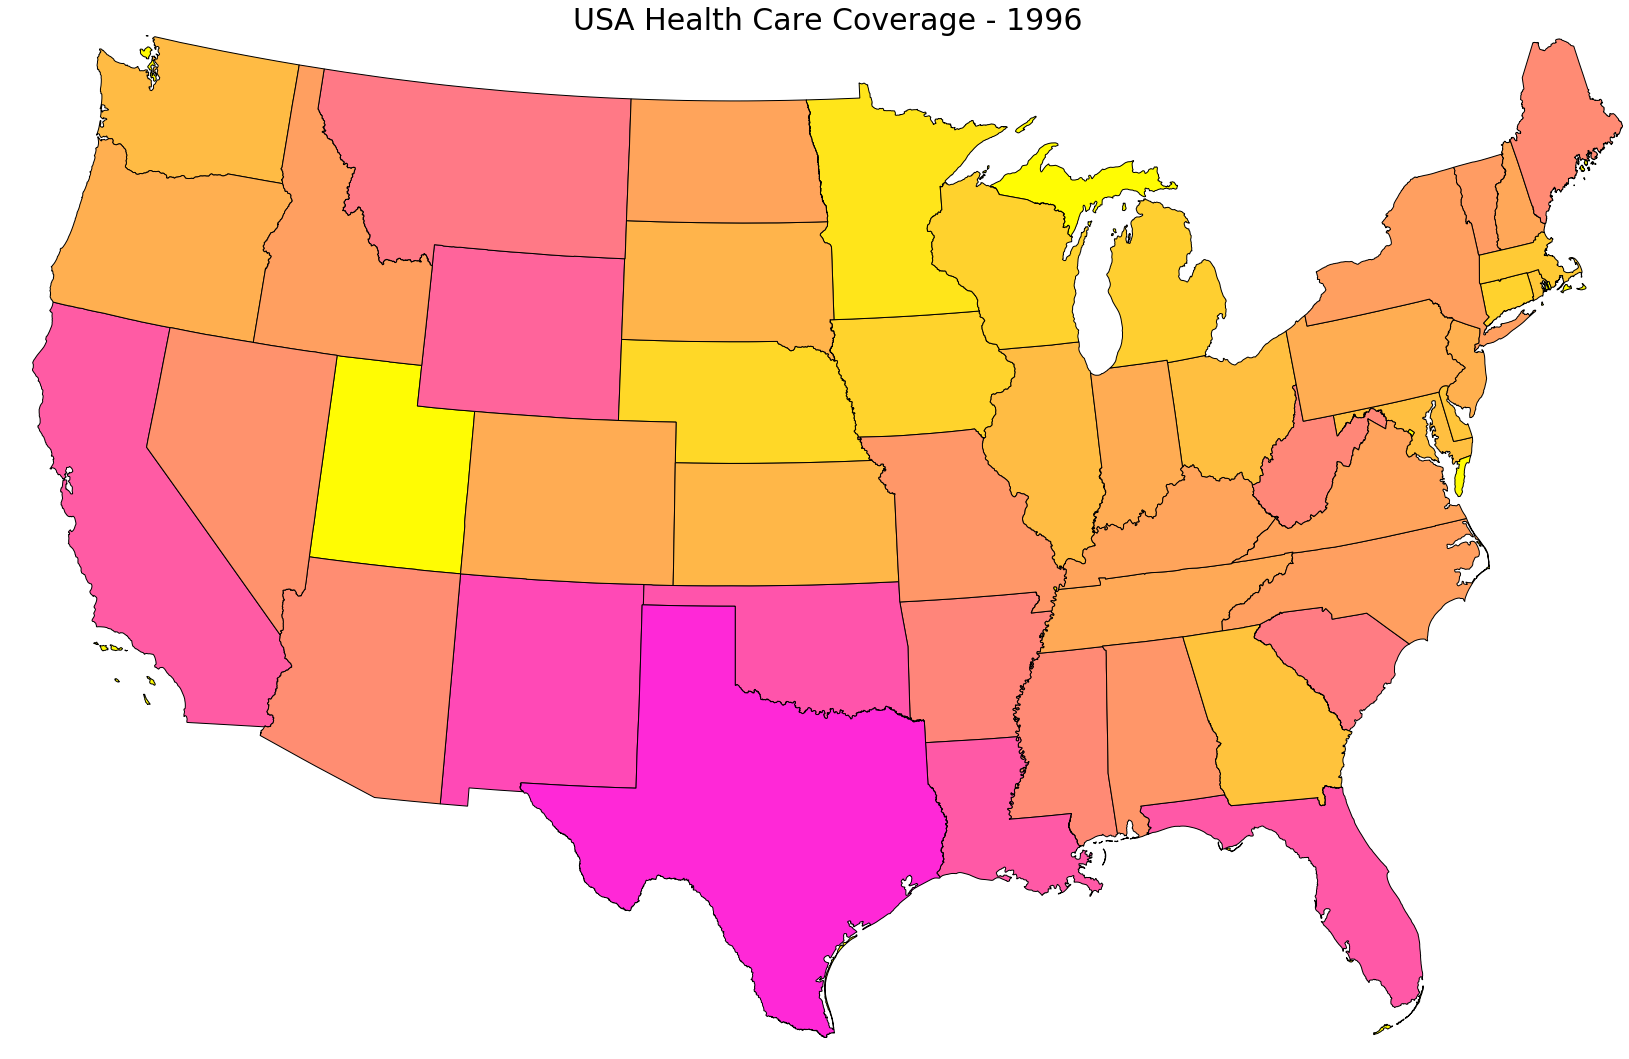

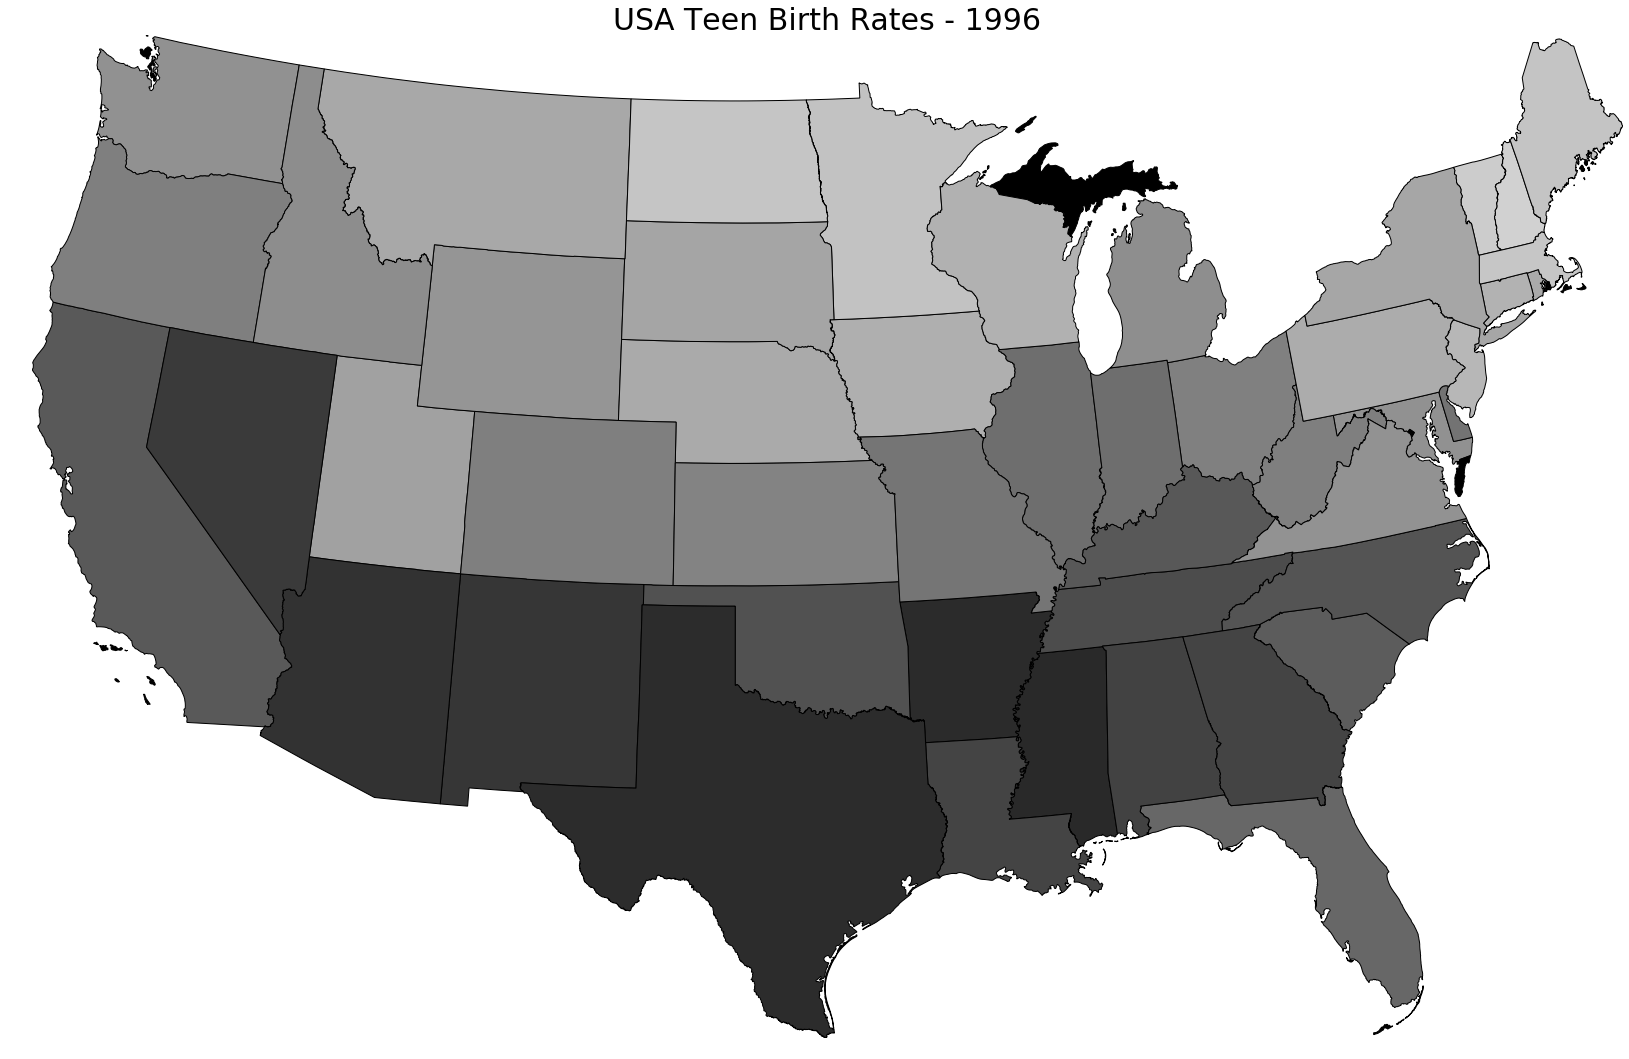

In [50]:
#for year in yearList:
 #   plotter(year)
plotter("1996")